# Processing and visualizing weather data for Ukrainian stations
### [NOAA Global Surface Summary of the Day](https://www.kaggle.com/noaa/noaa-global-surface-summary-of-the-day/version/2#readme.txt)

In [1]:
import numpy as np
import pandas as pd
import re

from urllib.request import urlopen

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px

#### Getting stations info from [Worldwide Station List](http://old.wetterzentrale.de/klima/stnlst.html)

In [38]:
url = 'http://old.wetterzentrale.de/klima/stnlst.html'
page = urlopen(url)
page

In [39]:
html_bytes = page.read()
html = html_bytes.decode('utf-8')
print(html[:1000])

<html>
<head>
<title>Worldwide Station List</title>
<BODY BGCOLOR="ffffff" LINK="#ff0000"
TEXT="000000" VLINK="#6666ff">
<h1>Worldwide Station List</h1>
<pre>
<font size=4>
 
NUMBER = STATION NUMBER  
CALL = STATION CALL LETTERS IF ASSIGNED  
NAME = NAME OF LOCATION (& INDICATES PREVIOUSLY UNDER DIFFERENT NUMBER)  
COUNTRY/STATE = 2-CHARACTER COUNTRY ABBREVIATION, FOR U.S.-- 
                2-CHARACTER STATE ABBREVIATION   
                (SEE 'COUNTRY-LIST.TXT' FILE)    
LAT = LATITUDE   
LON = LONGITUDE  
ELEV = ELEVATION IN METERS   
 
NUMBER CALL   NAME + COUNTRY/STATE   LAT   LON    ELEV (METERS)  
 
010010 ENJA   JAN MAYEN(NOR-NAVY) NO 7056N 00840W 0009   
010014 ENSO   STORD/SOERSTOKKEN   NO 5948N 00521E 0049   
010015 ENBL   FORDE/BRINGELAND    NO 6127N 00552E 0150   
010017 ENFR   FRIGG               NO 5956N 00200E    
010030        HORNSUND RIVER      NO 7700N 01530E 0012   
010040 ENAS   NY-ALESUND II       NO 7855N 01156E 0008   
010080 ENSB   SVALBARD/LONGYEAR   NO 7815

In [40]:
html_list[600]

'036095 EGFH   SWANSEA             UK 5136N 00404W 0090   '

In [41]:
html_list = html.split('\n')
html_list[600][34:36]

'UK'

#### Filtering out non-ukrainian stations by country code and removing country code

In [42]:
html_list = html.split('\n')
ua_raw = [x for x in html_list if  x[34:36] == 'UR']
ua_raw = [' '.join(x.split()) for x in ua_raw]
ua_raw = [x.replace(' UR ', ' ').replace(' (LH) ', ' ').replace(' & ', ' ') for x in ua_raw]
ua_raw

['330490 SEMENOVKA 5211N 03235E 0160',
 '330580 HUTOR MIHAJLOVSKIJ 5203N 03357E 0189',
 '330750 PNEVNO 5140N 02516E 0152',
 '330880 SARNY 5121N 02637E 0153',
 '331350 CERNIGOV 5129N 03117E 0137',
 '331360 VOLSKOVTSKY 5134N 03158E 0143',
 '331560 GLUKHOV 5141N 03355E 0180',
 "331730 KOVEL' 5113N 02441E 0176",
 '331770 VLADIMIR-VOLYNSKIJ 5050N 02419E 0193',
 '331870 LUCK 5045N 02520E 0196',
 '332130 OVRUC 5119N 02847E 0171',
 '332150 KOROSTEN 5057N 02839E 0189',
 '332280 TETEREV 5042N 02935E 0132',
 "332310 CERNOBYL' 5117N 03014E 0127",
 '332360 OSTER 5057N 03053E 0104',
 '332460 NEZIN 5103N 03154E 0126',
 '332610 KONOTOP 5114N 03312E 0149',
 '332680 ROMNY 5046N 03327E 0169',
 "332710 BELOPOL'E 5109N 03420E 0156",
 '332750 SUMY 5053N 03447E 0174',
 '332870 RAVA RUSSKAJA 5015N 02338E 0249',
 '332880 KAMENKA-BUGSKAYA 5006N 02421E 0228',
 '332970 BRODY 5006N 02509E 0227',
 '333010 ROVNO 5035N 02608E 0234',
 '333120 NOVGOROD VOLYNSKIJ 5036N 02737E 0218',
 '333170 SEPETOVKA 5010N 02703E 0278'

##### Removing remaining 4 symbol codes and replacing spaces in names with underscores

In [43]:
ua_stations = []
replacements = [('UK[A-Z]{2,2} ', ''), ('([A-Z]{1,1}) ([A-Z]{1,1})',  r'\1_\2')] 
for line in ua_raw:
    for old, new in replacements:
        line = re.sub(old, new, line)        
    ua_stations.append(line)
    
ua_stations = [x.split() for x in ua_stations if x[:6] != '338150' and x[:6] != '338920'] #kishinev and tiraspol codes
ua_stations

[['330490', 'SEMENOVKA', '5211N', '03235E', '0160'],
 ['330580', 'HUTOR_MIHAJLOVSKIJ', '5203N', '03357E', '0189'],
 ['330750', 'PNEVNO', '5140N', '02516E', '0152'],
 ['330880', 'SARNY', '5121N', '02637E', '0153'],
 ['331350', 'CERNIGOV', '5129N', '03117E', '0137'],
 ['331360', 'VOLSKOVTSKY', '5134N', '03158E', '0143'],
 ['331560', 'GLUKHOV', '5141N', '03355E', '0180'],
 ['331730', "KOVEL'", '5113N', '02441E', '0176'],
 ['331770', 'VLADIMIR-VOLYNSKIJ', '5050N', '02419E', '0193'],
 ['331870', 'LUCK', '5045N', '02520E', '0196'],
 ['332130', 'OVRUC', '5119N', '02847E', '0171'],
 ['332150', 'KOROSTEN', '5057N', '02839E', '0189'],
 ['332280', 'TETEREV', '5042N', '02935E', '0132'],
 ['332310', "CERNOBYL'", '5117N', '03014E', '0127'],
 ['332360', 'OSTER', '5057N', '03053E', '0104'],
 ['332460', 'NEZIN', '5103N', '03154E', '0126'],
 ['332610', 'KONOTOP', '5114N', '03312E', '0149'],
 ['332680', 'ROMNY', '5046N', '03327E', '0169'],
 ['332710', "BELOPOL'E", '5109N', '03420E', '0156'],
 ['332750', 

#### Forming dataframe of Ukrainian stations

In [44]:
uastations_df = pd.DataFrame(ua_stations, columns = ['number', 'name', 'lat', 'lon', 'elev'])
print(uastations_df.dtypes)
uastations_df

number    object
name      object
lat       object
lon       object
elev      object
dtype: object


,number,name,lat,lon,elev
0,330490,SEMENOVKA,5211N,03235E,0160
1,330580,HUTOR_MIHAJLOVSKIJ,5203N,03357E,0189
2,330750,PNEVNO,5140N,02516E,0152
3,330880,SARNY,5121N,02637E,0153
4,331350,CERNIGOV,5129N,03117E,0137
...,...,...,...,...,...
154,346150,VOLNOVAHA,4737N,03729E,0266
155,346220,AMVROSIEVKA,4748N,03830E,0172
156,347040,MILITOPOL',4650N,03522E,0039
157,347080,BOTEVO,4641N,03551E,0025


In [45]:
uastations_df['lat'] = uastations_df['lat'].apply(lambda x: int(x[:-1])*0.01)
uastations_df['lon'] = uastations_df['lon'].apply(lambda x: int(x[:-1])*0.01)
uastations_df[['number', 'elev']] = uastations_df[['number', 'elev']].astype(int)
print(uastations_df.dtypes)
uastations_df

number      int32
name       object
lat       float64
lon       float64
elev        int32
dtype: object


,number,name,lat,lon,elev
0,330490,SEMENOVKA,52.11,32.35,160
1,330580,HUTOR_MIHAJLOVSKIJ,52.03,33.57,189
2,330750,PNEVNO,51.40,25.16,152
3,330880,SARNY,51.21,26.37,153
4,331350,CERNIGOV,51.29,31.17,137
...,...,...,...,...,...
154,346150,VOLNOVAHA,47.37,37.29,266
155,346220,AMVROSIEVKA,47.48,38.30,172
156,347040,MILITOPOL',46.50,35.22,39
157,347080,BOTEVO,46.41,35.51,25


#### Plotting stations on map with plotly.scattergeo

In [46]:
fig = go.Figure(data=go.Scattergeo(
        text=uastations_df[['name','elev']],
        lat=uastations_df['lat'],
        lon=uastations_df['lon'],
        mode='markers',
        marker_color=uastations_df['elev'],
        ))

fig.update_layout(
    title='location of NOAA stations in Ukraine',
    width=800,
    height=800,
    geo=dict(
        scope='europe',
        projection=dict(
                scale=3
        ),
        center=dict(
                lat=52,
                lon=32
        )
    )
    )
fig.show()

#### Some stations are mistakingly set as Ukrainian, filtering them out

In [48]:
uastations_df[(uastations_df['lat']<=48.5) & (uastations_df['lon'] <=30)].sort_values(by='lon')

,number,name,lat,lon,elev
72,336310,UZGOROD,48.38,22.16,118
54,335170,PERECHIN,48.44,22.28,198
73,336450,YASNYA,48.16,24.22,731
74,336510,KOLOMYJA,48.32,25.02,298
75,336570,SELETIN,47.52,25.13,762
76,336580,CHERNIVTSI,48.22,25.54,246
58,335480,KAMENETS_PODOL'SKIJ,48.40,26.35,228
78,336640,BRICANY,48.22,27.06,238
77,336630,MOGILEV-PODOL'SKIJ,48.27,27.47,79
86,337450,BEL'CY,47.44,27.55,104


In [24]:
to_remove = ['BRICANY', 'BEL\'CY', 'KORNESTY', 'KAGUL', 'LEOVO','SOROKI', 'KOMRAT', 'KAMENKA', 'VORONKOVO']
crit = uastations_df['name'].map(lambda x: not x in to_remove)
uastations_df = uastations_df[crit]
uastations_df[(uastations_df['lat']<=48.5) & (uastations_df['lon'] <=30)].sort_values(by='lat')

,number,name,lat,lon,elev
104,338890,IZMAIL,45.22,28.52,30
105,338960,SARATA,46.01,29.40,14
75,336570,SELETIN,47.52,25.13,762
73,336450,YASNYA,48.16,24.22,731
76,336580,CHERNIVTSI,48.22,25.54,246
77,336630,MOGILEV-PODOL'SKIJ,48.27,27.47,79
74,336510,KOLOMYJA,48.32,25.02,298
72,336310,UZGOROD,48.38,22.16,118
58,335480,KAMENETS_PODOL'SKIJ,48.40,26.35,228
54,335170,PERECHIN,48.44,22.28,198


#### Fixing lat&lon for Kriviy Rih

In [50]:
uastations_df[uastations_df['lat'] == min(uastations_df['lat'])]

,number,name,lat,lon,elev
92,337910,KRYVYI_RIH,43.02,33.13,125


In [51]:
uastations_df.loc[92, ['lat', 'lon']] = [47.54, 33.20]

In [53]:
fig = go.Figure(data=go.Scattergeo(
        text=uastations_df[['name','elev']],
        lat=uastations_df['lat'],
        lon=uastations_df['lon'],
        mode='markers',
        marker_color=uastations_df['elev'],
        ))

fig.update_layout(
    title='location of NOAA stations in Ukraine',
    width=800,
    height=800,
    geo=dict(
        scope='europe',
        projection=dict(
                scale=4.5
        ),
        center=dict(
                lat=52,
                lon=32
        )
    )
    )
fig.show()

#### Uploading NOAA GSOD ukrainian data gathered by third party

In [54]:
raw1 = pd.read_csv('gsod_ua_1.csv', error_bad_lines=False)
raw2 = pd.read_csv('gsod_ua_2.csv', error_bad_lines=False)
raw = pd.concat([raw1, raw2])
raw.head()

b'Skipping line 73678: expected 22 fields, saw 43\nSkipping line 75263: expected 22 fields, saw 40\n'
b'Skipping line 145412: expected 22 fields, saw 43\nSkipping line 145466: expected 22 fields, saw 44\nSkipping line 145519: expected 22 fields, saw 41\nSkipping line 145520: expected 22 fields, saw 24\nSkipping line 145573: expected 22 fields, saw 24\nSkipping line 145574: expected 22 fields, saw 41\n'
b'Skipping line 216874: expected 22 fields, saw 42\nSkipping line 223818: expected 22 fields, saw 30\n'
b'Skipping line 233031: expected 22 fields, saw 43\n'
b'Skipping line 504056: expected 22 fields, saw 44\nSkipping line 504111: expected 22 fields, saw 38\nSkipping line 509342: expected 22 fields, saw 42\nSkipping line 509396: expected 22 fields, saw 43\nSkipping line 509449: expected 22 fields, saw 44\nSkipping line 509502: expected 22 fields, saw 43\n'
c:\python38\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning:

Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,1

,STN---,WBAN,YEARMODA,TEMP,TEMP_COUNT,DEWP,DEWP_COUNT,SLP,SLP_COUNT,STP,...,VISIB_COUNT,WDSP,WDSP_COUNT,MXSPD,GUST,MAX,MIN,PRCP,SNDP,FRSHTT
0,336310,99999,19831105,44.8,8,39.5,8,1020.5,6,9999.9,...,8,1.2,8,3.9,999.9,53.1*,35.8,0.00G,999.9,0.0
1,336310,99999,19831106,43.8,8,40.6,8,1024.6,8,9999.9,...,8,1.2,8,5.8,999.9,54.3,35.2,0.00G,999.9,100000.0
2,336310,99999,19831107,37.9,8,37.5,8,1028.9,7,9999.9,...,8,2.2,8,5.8,999.9,46.8,30.4,0.00G,999.9,110000.0
3,336310,99999,19831108,37.0,7,36.6,7,1029.2,7,9999.9,...,7,1.4,7,3.9,999.9,39.9*,32.2,0.00G,999.9,110000.0
4,336310,99999,19831109,39.1,7,38.6,7,1029.0,7,9999.9,...,7,2.5,7,3.9,999.9,40.6,37.4,0.02G,999.9,10000.0


In [55]:
raw = raw[raw['STN---'].isin(uastations_df['number'])].reset_index(drop=True)
raw

,STN---,WBAN,YEARMODA,TEMP,TEMP_COUNT,DEWP,DEWP_COUNT,SLP,SLP_COUNT,STP,...,VISIB_COUNT,WDSP,WDSP_COUNT,MXSPD,GUST,MAX,MIN,PRCP,SNDP,FRSHTT
0,336310,99999,19831105,44.8,8,39.5,8,1020.5,6,9999.9,...,8,1.2,8,3.9,999.9,53.1*,35.8,0.00G,999.9,0.0
1,336310,99999,19831106,43.8,8,40.6,8,1024.6,8,9999.9,...,8,1.2,8,5.8,999.9,54.3,35.2,0.00G,999.9,100000.0
2,336310,99999,19831107,37.9,8,37.5,8,1028.9,7,9999.9,...,8,2.2,8,5.8,999.9,46.8,30.4,0.00G,999.9,110000.0
3,336310,99999,19831108,37.0,7,36.6,7,1029.2,7,9999.9,...,7,1.4,7,3.9,999.9,39.9*,32.2,0.00G,999.9,110000.0
4,336310,99999,19831109,39.1,7,38.6,7,1029.0,7,9999.9,...,7,2.5,7,3.9,999.9,40.6,37.4,0.02G,999.9,10000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462051,336140,99999.0,20010316.0,38.6,8.0,34.5,8.0,1008.5,8.0,9999.9,...,8.0,10.0,8.0,17.5,999.9,43.9,34.9,0.43E,999.9,10000.0
462052,336140,99999.0,20010317.0,44.1,8.0,37.8,8.0,1009.5,8.0,9999.9,...,8.0,4.6,8.0,7.8,999.9,51.8,36.5,0.02E,999.9,10000.0
462053,336140,99999.0,20010318.0,45.2,8.0,42.5,8.0,1001.2,8.0,9999.9,...,8.0,3.6,8.0,7.8,999.9,51.3,41.5*,0.04F,999.9,110000.0
462054,336140,99999.0,20010319.0,38.4,8.0,32.3,8.0,1009.2,8.0,9999.9,...,8.0,7.5,8.0,13.6,999.9,42.1,34.7,0.04E,999.9,11000.0


In [56]:
raw.columns

Index(['STN---', 'WBAN', 'YEARMODA', 'TEMP', 'TEMP_COUNT', 'DEWP',
       'DEWP_COUNT', 'SLP', 'SLP_COUNT', 'STP', 'STP_COUNT', 'VISIB',
       'VISIB_COUNT', 'WDSP', 'WDSP_COUNT', 'MXSPD', 'GUST', 'MAX', 'MIN',
       'PRCP', 'SNDP', 'FRSHTT'],
      dtype='object')

In [57]:
rename = {'STN---': 'number', 'YEARMODA': 'date', 'TEMP': 'temp', 'TEMP_COUNT': 'tempcount', 'SLP': 'meanslp',
          'SLP_COUNT': 'slpcount', 'STP': 'meanstp', 'STP_COUNT': 'stpcount', 'VISIB': 'meanvisib', 'VISIB_COUNT': 'visibcount',
         'WDSP': 'meanwindsp', 'WDSP_COUNT': 'windspcount', 'MXSPD': 'maxwindsp', 'GUST': 'maxwindgust', 'MAX': 'maxtemp',
         'MIN': 'mintemp', 'PRCP': 'precipitation', 'SNDP': 'snowdepth', 'FRSHTT': 'eventobs'}

#### Renaming columns

In [58]:
df = raw.rename(columns=rename).drop(['WBAN', 'DEWP', 'DEWP_COUNT'], axis=1)
df

,number,date,temp,tempcount,meanslp,slpcount,meanstp,stpcount,meanvisib,visibcount,meanwindsp,windspcount,maxwindsp,maxwindgust,maxtemp,mintemp,precipitation,snowdepth,eventobs
0,336310,19831105,44.8,8,1020.5,6,9999.9,0,2.5,8,1.2,8,3.9,999.9,53.1*,35.8,0.00G,999.9,0.0
1,336310,19831106,43.8,8,1024.6,8,9999.9,0,1.3,8,1.2,8,5.8,999.9,54.3,35.2,0.00G,999.9,100000.0
2,336310,19831107,37.9,8,1028.9,7,9999.9,0,0.0,8,2.2,8,5.8,999.9,46.8,30.4,0.00G,999.9,110000.0
3,336310,19831108,37.0,7,1029.2,7,9999.9,0,0.0,7,1.4,7,3.9,999.9,39.9*,32.2,0.00G,999.9,110000.0
4,336310,19831109,39.1,7,1029.0,7,9999.9,0,0.2,7,2.5,7,3.9,999.9,40.6,37.4,0.02G,999.9,10000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462051,336140,20010316.0,38.6,8.0,1008.5,8.0,9999.9,0.0,7.6,8.0,10.0,8.0,17.5,999.9,43.9,34.9,0.43E,999.9,10000.0
462052,336140,20010317.0,44.1,8.0,1009.5,8.0,9999.9,0.0,6.8,8.0,4.6,8.0,7.8,999.9,51.8,36.5,0.02E,999.9,10000.0
462053,336140,20010318.0,45.2,8.0,1001.2,8.0,9999.9,0.0,5.1,8.0,3.6,8.0,7.8,999.9,51.3,41.5*,0.04F,999.9,110000.0
462054,336140,20010319.0,38.4,8.0,1009.2,8.0,9999.9,0.0,9.1,8.0,7.5,8.0,13.6,999.9,42.1,34.7,0.04E,999.9,11000.0


#### Fixing data types

In [59]:
df['date'] = pd.to_datetime(df['date'].astype(int).astype(str))

In [60]:
df[['number', 'tempcount', 'slpcount', 'stpcount', 'visibcount', 'windspcount', 'eventobs']] \
        = df[['number', 'tempcount', 'slpcount', 'stpcount', 'visibcount', 'windspcount', 'eventobs']].astype(int)

In [61]:
def process(val):
    return ''.join(x for x in val if x.isdigit() or x in ('-', '.'))

In [62]:
df['maxtemp'] = df['maxtemp'].astype(str).apply(lambda x: process(x))
df['mintemp'] = df['mintemp'].astype(str).apply(lambda x: process(x))
df['precipitation'] = df['precipitation'].astype(str).apply(lambda x: process(x))

In [63]:
df[['temp', 'meanslp', 'meanstp', 'maxtemp', 'mintemp']] \
    = df[['temp', 'meanslp', 'meanstp', 'maxtemp', 'mintemp']].astype(str).replace('9999.9', np.nan).astype(float)

df[['meanvisib', 'meanwindsp', 'maxwindsp', 'maxwindgust', 'snowdepth']]\
    = df[['meanvisib', 'meanwindsp', 'maxwindsp', 'maxwindgust', 'snowdepth']].astype(str).replace('999.9', np.nan).astype(float)

df['precipitation'] = df['precipitation'].replace('99.99', np.nan).astype(float)

In [64]:
df

,number,date,temp,tempcount,meanslp,slpcount,meanstp,stpcount,meanvisib,visibcount,meanwindsp,windspcount,maxwindsp,maxwindgust,maxtemp,mintemp,precipitation,snowdepth,eventobs
0,336310,1983-11-05,44.8,8,1020.5,6,NaN,0,2.5,8,1.2,8,3.9,NaN,53.1,35.8,0.00,NaN,0
1,336310,1983-11-06,43.8,8,1024.6,8,NaN,0,1.3,8,1.2,8,5.8,NaN,54.3,35.2,0.00,NaN,100000
2,336310,1983-11-07,37.9,8,1028.9,7,NaN,0,0.0,8,2.2,8,5.8,NaN,46.8,30.4,0.00,NaN,110000
3,336310,1983-11-08,37.0,7,1029.2,7,NaN,0,0.0,7,1.4,7,3.9,NaN,39.9,32.2,0.00,NaN,110000
4,336310,1983-11-09,39.1,7,1029.0,7,NaN,0,0.2,7,2.5,7,3.9,NaN,40.6,37.4,0.02,NaN,10000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462051,336140,2001-03-16,38.6,8,1008.5,8,NaN,0,7.6,8,10.0,8,17.5,NaN,43.9,34.9,0.43,NaN,10000
462052,336140,2001-03-17,44.1,8,1009.5,8,NaN,0,6.8,8,4.6,8,7.8,NaN,51.8,36.5,0.02,NaN,10000
462053,336140,2001-03-18,45.2,8,1001.2,8,NaN,0,5.1,8,3.6,8,7.8,NaN,51.3,41.5,0.04,NaN,110000
462054,336140,2001-03-19,38.4,8,1009.2,8,NaN,0,9.1,8,7.5,8,13.6,NaN,42.1,34.7,0.04,NaN,11000


In [65]:
df.dtypes

number                    int32
date             datetime64[ns]
temp                    float64
tempcount                 int32
meanslp                 float64
slpcount                  int32
meanstp                 float64
stpcount                  int32
meanvisib               float64
visibcount                int32
meanwindsp              float64
windspcount               int32
maxwindsp               float64
maxwindgust             float64
maxtemp                 float64
mintemp                 float64
precipitation           float64
snowdepth               float64
eventobs                  int32
dtype: object

#### Merging GSOD data with UA station frame to add stations info

In [66]:
mrg = df.merge(uastations_df, on='number', suffixes=('','_y'))
cols = list(mrg.columns.values)
cols.pop(cols.index('number'))
cols.pop(cols.index('name'))
df = mrg[['number', 'name'] + cols]
df['name'] = df['name'].astype(str).replace('BORISPOL\'/KEIV', 'BORISPOL\'/KIEV')
df

,number,name,date,temp,tempcount,meanslp,slpcount,meanstp,stpcount,meanvisib,...,maxwindsp,maxwindgust,maxtemp,mintemp,precipitation,snowdepth,eventobs,lat,lon,elev
0,336310,UZGOROD,1983-11-05,44.8,8,1020.5,6,NaN,0,2.5,...,3.9,NaN,53.1,35.8,0.00,NaN,0,48.38,22.16,118
1,336310,UZGOROD,1983-11-06,43.8,8,1024.6,8,NaN,0,1.3,...,5.8,NaN,54.3,35.2,0.00,NaN,100000,48.38,22.16,118
2,336310,UZGOROD,1983-11-07,37.9,8,1028.9,7,NaN,0,0.0,...,5.8,NaN,46.8,30.4,0.00,NaN,110000,48.38,22.16,118
3,336310,UZGOROD,1983-11-08,37.0,7,1029.2,7,NaN,0,0.0,...,3.9,NaN,39.9,32.2,0.00,NaN,110000,48.38,22.16,118
4,336310,UZGOROD,1983-11-09,39.1,7,1029.0,7,NaN,0,0.2,...,3.9,NaN,40.6,37.4,0.02,NaN,10000,48.38,22.16,118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462051,335170,PERECHIN,1959-11-13,29.8,4,NaN,0,NaN,0,9.3,...,NaN,NaN,57.0,27.0,0.00,NaN,0,48.44,22.28,198
462052,335170,PERECHIN,1959-12-10,35.7,4,NaN,0,NaN,0,9.3,...,NaN,NaN,41.0,34.0,0.00,NaN,0,48.44,22.28,198
462053,335170,PERECHIN,1961-07-16,62.5,4,NaN,0,NaN,0,10.9,...,8.0,NaN,77.0,46.0,0.04,NaN,0,48.44,22.28,198
462054,335170,PERECHIN,1961-09-30,47.0,4,NaN,0,NaN,0,12.4,...,4.1,NaN,64.0,36.0,0.00,NaN,0,48.44,22.28,198


#### Formating data

In [67]:
def frh_to_celc(val):
    return round((val-32)*5/9, 1)

def mls_to_km(val):
    return round(val*1.609, 1)

def knots_to_mps(val):
    return round(val/1.944, 1)

def inchs_to_cm(val):
    return round(val*2.54, 2)

In [68]:
df[['temp', 'mintemp', 'maxtemp']] = df[['temp', 'mintemp', 'maxtemp']].apply(lambda x: frh_to_celc(x))
df['meanvisib'] = df['meanvisib'].apply(lambda x: mls_to_km(x))
df[['meanwindsp', 'maxwindsp', 'maxwindgust']] = df[['meanwindsp', 'maxwindsp', 'maxwindgust']].apply(lambda x: knots_to_mps(x))
df[['precipitation', 'snowdepth']] = df[['precipitation', 'snowdepth']].apply(lambda x: inchs_to_cm(x))
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

In [69]:
df

,number,name,date,temp,tempcount,meanslp,slpcount,meanstp,stpcount,meanvisib,...,maxtemp,mintemp,precipitation,snowdepth,eventobs,lat,lon,elev,year,month
0,336310,UZGOROD,1983-11-05,7.1,8,1020.5,6,NaN,0,4.0,...,11.7,2.1,0.00,NaN,0,48.38,22.16,118,1983,11
1,336310,UZGOROD,1983-11-06,6.6,8,1024.6,8,NaN,0,2.1,...,12.4,1.8,0.00,NaN,100000,48.38,22.16,118,1983,11
2,336310,UZGOROD,1983-11-07,3.3,8,1028.9,7,NaN,0,0.0,...,8.2,-0.9,0.00,NaN,110000,48.38,22.16,118,1983,11
3,336310,UZGOROD,1983-11-08,2.8,7,1029.2,7,NaN,0,0.0,...,4.4,0.1,0.00,NaN,110000,48.38,22.16,118,1983,11
4,336310,UZGOROD,1983-11-09,3.9,7,1029.0,7,NaN,0,0.3,...,4.8,3.0,0.05,NaN,10000,48.38,22.16,118,1983,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462051,335170,PERECHIN,1959-11-13,-1.2,4,NaN,0,NaN,0,15.0,...,13.9,-2.8,0.00,NaN,0,48.44,22.28,198,1959,11
462052,335170,PERECHIN,1959-12-10,2.1,4,NaN,0,NaN,0,15.0,...,5.0,1.1,0.00,NaN,0,48.44,22.28,198,1959,12
462053,335170,PERECHIN,1961-07-16,16.9,4,NaN,0,NaN,0,17.5,...,25.0,7.8,0.10,NaN,0,48.44,22.28,198,1961,7
462054,335170,PERECHIN,1961-09-30,8.3,4,NaN,0,NaN,0,20.0,...,17.8,2.2,0.00,NaN,0,48.44,22.28,198,1961,9


In [70]:
df.value_counts('year').head(20)

year
1984    27399
2015    23914
1994    20858
1970    19460
1969    19215
1989    18382
1988    18255
1977    18195
1997    15900
1987    15784
1978    14979
2016    14322
2012    12775
2002    12748
1982    12285
2000    12123
1976    11449
2011    10950
2009    10949
1998    10648
dtype: int64

In [71]:
geoscat_df = df[df['year']==2015].groupby(['name', 'month'], as_index=False).mean()
geoscat_df

,name,month,number,temp,tempcount,meanslp,slpcount,meanstp,stpcount,meanvisib,...,maxwindgust,maxtemp,mintemp,precipitation,snowdepth,eventobs,lat,lon,elev,year
0,ASKANIJA-NOVA,1,339150.0,-0.235484,7.064516,1018.390323,7.064516,1014.603226,7.064516,10.087097,...,NaN,2.070968,-2.535484,0.067778,2.034545,38516.129032,46.27,33.53,28.0,2015
1,ASKANIJA-NOVA,2,339150.0,0.671429,7.535714,1018.278571,7.535714,1014.496429,7.535714,16.228571,...,NaN,5.000000,-2.928571,0.126786,1.526667,12642.857143,46.27,33.53,28.0,2015
2,ASKANIJA-NOVA,3,339150.0,4.977419,7.483871,1021.406452,7.483871,1017.674194,7.483871,16.051613,...,NaN,9.819355,0.354839,0.166452,NaN,9677.419355,46.27,33.53,28.0,2015
3,ASKANIJA-NOVA,4,339150.0,7.788889,7.333333,1009.477778,7.333333,1005.833333,7.333333,16.555556,...,NaN,12.944444,3.477778,0.295556,NaN,17778.888889,46.27,33.53,28.0,2015
4,ASKANIJA-NOVA,5,339150.0,16.719355,7.645161,1013.541935,7.645161,1009.990323,7.645161,18.480645,...,NaN,23.100000,10.280645,0.140968,NaN,5807.096774,46.27,33.53,28.0,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
832,ZNAMENKA,8,336090.0,20.858065,7.935484,1018.345161,7.935484,997.296774,7.935484,11.893548,...,NaN,27.535484,14.070968,0.112903,NaN,645.483871,48.43,32.40,181.0,2015
833,ZNAMENKA,9,336090.0,18.442857,7.714286,1017.192857,7.714286,995.989286,7.714286,12.089286,...,NaN,25.960714,12.135714,0.085357,NaN,357.857143,48.43,32.40,181.0,2015
834,ZNAMENKA,10,336090.0,6.567742,7.838710,1023.680645,7.838710,1001.403226,7.838710,11.119355,...,NaN,12.887097,1.400000,0.041935,NaN,1290.322581,48.43,32.40,181.0,2015
835,ZNAMENKA,11,336090.0,4.523333,7.400000,1016.513333,7.400000,994.243333,7.400000,7.026667,...,NaN,7.473333,1.993333,0.177333,NaN,24733.333333,48.43,32.40,181.0,2015


#### Plotting average monthly temperature by month for the latest year with largest ammount of data

In [72]:
fig = px.scatter_geo(geoscat_df,lat='lat', lon='lon', animation_frame='month', animation_group='temp',hover_name='name',
     color='temp')

fig["layout"].pop("updatemenus")
fig.update_layout(
    title='motnhtly average temperature in 2015',
    width=800,
    height=800,
    geo=dict(
        scope='europe',
        projection=dict(
                scale=4.5
        ),
        center=dict(
                lat=52,
                lon=32
        )
    )
    )
fig.show()

#### Filtering Kyiv stations and getting observations columns

In [73]:
kievid = df[df['name'].str.contains('KIEV')]['number'].unique()
kievid

array([333450, 333470])

In [74]:
def getobs(val, pos):
    try:
        return int(val[pos])
    except:
        return 0
getobs('10000', 6)

0

In [75]:
kievdf = df[df['number'].isin(kievid)]
kievdf['eventobs'] = kievdf['eventobs'].astype(str)
kievdf['fog'] = kievdf['eventobs'].apply(lambda x: getobs(x,0));
kievdf['rain'] = kievdf['eventobs'].apply(lambda x: getobs(x,1));
kievdf['snow'] = kievdf['eventobs'].apply(lambda x: getobs(x,2));
kievdf['hail'] = kievdf['eventobs'].apply(lambda x: getobs(x,3));
kievdf['thunder'] = kievdf['eventobs'].apply(lambda x: getobs(x,4));
kievdf['tornado'] = kievdf['eventobs'].apply(lambda x: getobs(x,5));
kievdf

<ipython-input-75-f0c43ec173f9>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-75-f0c43ec173f9>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-75-f0c43ec173f9>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-75-f0c43ec

,number,name,date,temp,tempcount,meanslp,slpcount,meanstp,stpcount,meanvisib,...,lon,elev,year,month,fog,rain,snow,hail,thunder,tornado
288129,333450,KIEV/ZHULYANY,2002-01-01,-10.7,7,1020.0,7,NaN,0,15.4,...,30.27,168,2002,1,1,0,0,0,0,0
288130,333450,KIEV/ZHULYANY,2002-01-02,-5.5,10,1010.9,8,NaN,0,7.7,...,30.27,168,2002,1,1,0,0,0,0,0
288131,333450,KIEV/ZHULYANY,2002-01-03,-5.8,18,1027.5,7,NaN,0,8.8,...,30.27,168,2002,1,1,0,0,0,0,0
288132,333450,KIEV/ZHULYANY,2002-01-04,-11.5,18,1033.0,7,NaN,0,12.2,...,30.27,168,2002,1,1,0,0,0,0,0
288133,333450,KIEV/ZHULYANY,2002-01-05,-8.6,19,1026.4,8,NaN,0,6.0,...,30.27,168,2002,1,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303724,333470,BORISPOL'/KIEV,2001-12-27,-8.7,23,NaN,0,NaN,0,3.5,...,30.58,119,2001,12,1,0,0,0,0,0
303725,333470,BORISPOL'/KIEV,2001-12-28,-3.2,23,NaN,0,NaN,0,0.8,...,30.58,119,2001,12,1,0,1,0,0,0
303726,333470,BORISPOL'/KIEV,2001-12-29,-2.4,23,NaN,0,NaN,0,5.3,...,30.58,119,2001,12,1,0,1,0,0,0
303727,333470,BORISPOL'/KIEV,2001-12-30,-1.6,21,NaN,0,NaN,0,5.6,...,30.58,119,2001,12,1,0,0,0,0,0


In [76]:
kievdf['year'].max()

2016

In [77]:
kiev2016 = kievdf[kievdf['year'] == 2016]
kiev2016['day'] = kiev2016.date.dt.day
kiev2016

<ipython-input-77-58b4f566c47b>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,number,name,date,temp,tempcount,meanslp,slpcount,meanstp,stpcount,meanvisib,...,elev,year,month,fog,rain,snow,hail,thunder,tornado,day
291198,333450,KIEV/ZHULYANY,2016-01-01,-11.7,24,NaN,0,NaN,0,6.1,...,168,2016,1,1,0,0,0,0,0,1
291199,333450,KIEV/ZHULYANY,2016-01-02,-15.9,24,NaN,0,NaN,0,7.2,...,168,2016,1,1,0,0,0,0,0,2
291200,333450,KIEV/ZHULYANY,2016-01-03,-17.9,24,NaN,0,NaN,0,7.4,...,168,2016,1,1,0,0,0,0,0,3
291201,333450,KIEV/ZHULYANY,2016-01-04,-16.8,24,NaN,0,NaN,0,7.2,...,168,2016,1,1,0,0,0,0,0,4
291202,333450,KIEV/ZHULYANY,2016-01-05,-11.9,24,NaN,0,NaN,0,6.6,...,168,2016,1,1,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301785,333470,BORISPOL'/KIEV,2016-12-27,2.6,24,NaN,0,NaN,0,9.5,...,119,2016,12,1,0,0,0,0,0,27
301786,333470,BORISPOL'/KIEV,2016-12-28,0.8,24,NaN,0,NaN,0,9.0,...,119,2016,12,1,1,0,0,0,0,28
301787,333470,BORISPOL'/KIEV,2016-12-29,-0.7,24,NaN,0,NaN,0,9.7,...,119,2016,12,1,0,0,0,0,0,29
301788,333470,BORISPOL'/KIEV,2016-12-30,-2.6,24,NaN,0,NaN,0,10.0,...,119,2016,12,0,0,0,0,0,0,30


In [78]:
grp = kiev2016.groupby(['name', 'month'], sort=False).mean()
grp

number       temp  tempcount  meanslp  slpcount  \
name           month                                                      
KIEV/ZHULYANY  1      333450.0  -5.738710  24.000000      NaN       0.0   
               2      333450.0   1.934483  23.724138      NaN       0.0   
               3      333450.0   3.793548  23.838710      NaN       0.0   
               4      333450.0  11.963333  24.000000      NaN       0.0   
               5      333450.0  15.190323  24.000000      NaN       0.0   
               6      333450.0  20.223333  24.000000      NaN       0.0   
               7      333450.0  21.851613  24.000000      NaN       0.0   
               8      333450.0  20.380645  24.000000      NaN       0.0   
               9      333450.0  15.106667  24.000000      NaN       0.0   
               10     333450.0   6.219355  24.000000      NaN       0.0   
               11     333450.0   1.166667  23.966667      NaN       0.0   
               12     333450.0  -1.719355  24.000000      NaN       0.0   
BORISPOL'/KIEV 1      333470.0  -6.593548  24.000000      NaN       0.0   
               2      333470.0   1.562069  23.793103      NaN       0.0   
               3      333470.0   3.648387  23.774194      NaN       0.0   
               4      333470.0  11.536667  24.000000      NaN       0.0   
               5      333470.0  14.838710  24.000000      NaN       0.0   
               6      333470.0  19.753333  24.000000      NaN       0.0   
               7      333470.0  21.709677  24.000000      NaN       0.0   
               8      333470.0  20.151613  24.000000      NaN       0.0   
               9      333470.0  14.423333  24.000000      NaN       0.0   
               10     333470.0   6.032258  24.000000      NaN       0.0   
               11     333470.0   0.740000  23.966667      NaN       0.0   
               12     333470.0  -1.887097  24.000000      NaN       0.0   

                      meanstp  stpcount  meanvisib  visibcount  meanwindsp  \
name           month                                                         
KIEV/ZHULYANY  1          NaN       0.0   6.970968   21.516129    4.212903   
               2          NaN       0.0   8.337037   17.344828    4.041379   
               3          NaN       0.0   8.706667   18.709677    3.996774   
               4          NaN       0.0   8.887500    9.566667    3.630000   
               5          NaN       0.0   9.450000   12.612903    3.000000   
               6          NaN       0.0  10.095238    7.233333    3.103333   
               7          NaN       0.0   9.826923    9.387097    3.535484   
               8          NaN       0.0   9.825926    8.806452    2.822581   
               9          NaN       0.0   9.907692    9.000000    2.873333   
               10         NaN       0.0   8.373333   19.161290    3.767742   
               11         NaN       0.0   8.273333   21.600000    4.063333   
               12         NaN       0.0   7.412903   21.451613    4.787097   
BORISPOL'/KIEV 1          NaN       0.0   7.206452   20.419355    4.096774   
               2          NaN       0.0   8.455556   16.000000    4.437931   
               3          NaN       0.0   8.744444   16.903226    4.122581   
               4          NaN       0.0   8.695238    8.566667    3.553333   
               5          NaN       0.0   9.079167   11.612903    3.100000   
               6          NaN       0.0   9.168421    6.900000    3.383333   
               7          NaN       0.0   9.094737    7.290323    3.651613   
               8          NaN       0.0   8.766667    5.451613    3.287097   
               9          NaN       0.0   8.943750    5.866667    2.880000   
               10         NaN       0.0   8.572414   18.419355    3.835484   
               11         NaN       0.0   8.413333   20.900000    4.283333   
               12         NaN       0.0   7.963333   20.193548    4.106452   

                      ...    lon   elev    y

In [79]:
tmp1 = grp.loc['KIEV/ZHULYANY', 'temp']
tmp2 = grp.loc['BORISPOL\'/KIEV', 'temp']
xax = kiev2016['date'].dt.month_name().unique()

#### Plotting Kyiv monthly mean temperature in 2016 with pyplot

c:\python38\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

c:\python38\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



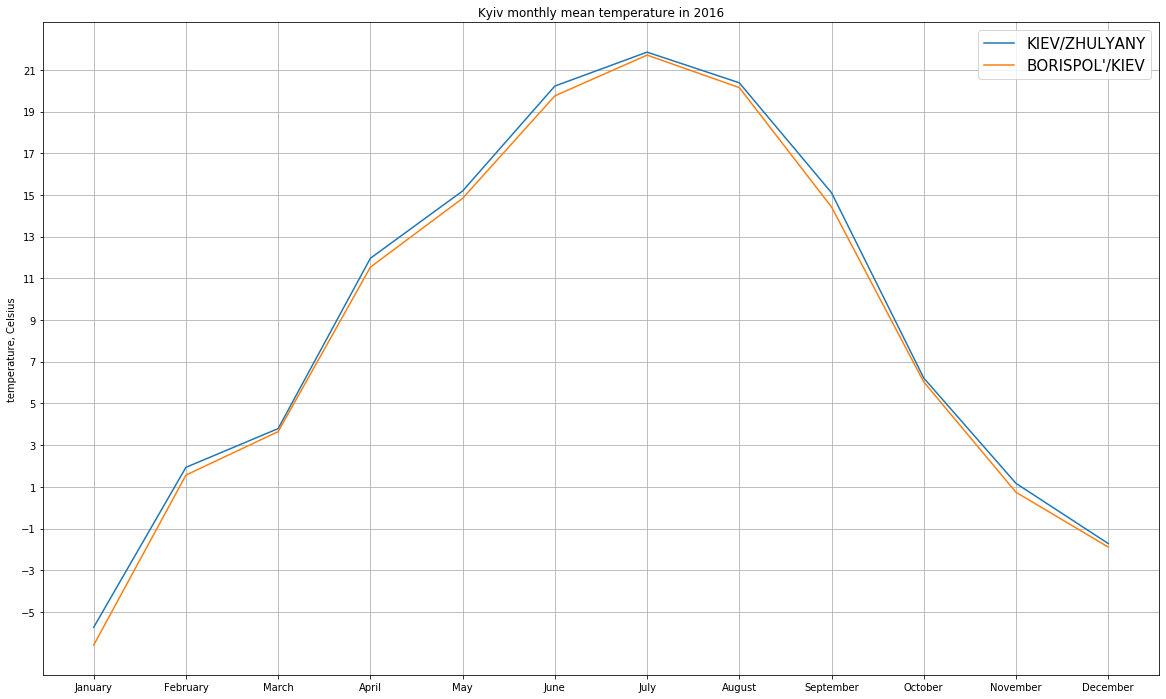

In [90]:
fix, ax = plt.subplots(figsize = (20, 12));
plt.yticks(np.arange(int(min(tmp1)), int(max(tmp1)+2), 2.0));
plt.grid();
plt.title('Kyiv monthly mean temperature in 2016');
plt.ylabel('temperature, Celsius');
ax.plot(xax, tmp1, label='KIEV/ZHULYANY');
ax.plot(xax, tmp2, label='BORISPOL\'/KIEV');
ax.legend(prop={'size': 15});

In [81]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
from jupyter_plotly_dash import JupyterDash

In [82]:
kiev_grp = kievdf.groupby(['name', 'year', 'month'], as_index=False).mean()
kiev_grp

,name,year,month,number,temp,tempcount,meanslp,slpcount,meanstp,stpcount,...,snowdepth,lat,lon,elev,fog,rain,snow,hail,thunder,tornado
0,BORISPOL'/KIEV,1961,9,333470.0,10.300000,4.000000,NaN,0.000000,NaN,0.0,...,NaN,50.20,30.58,119.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.0
1,BORISPOL'/KIEV,1977,10,333470.0,5.904167,4.958333,NaN,0.000000,NaN,0.0,...,NaN,50.20,30.58,119.0,0.291667,0.000000,0.000000,0.000000,0.000000,0.0
2,BORISPOL'/KIEV,1977,11,333470.0,3.418182,5.136364,1008.150,3.727273,NaN,0.0,...,NaN,50.20,30.58,119.0,0.681818,0.272727,0.000000,0.000000,0.000000,0.0
3,BORISPOL'/KIEV,1977,12,333470.0,-5.260000,5.520000,1020.412,5.520000,NaN,0.0,...,3.560000,50.20,30.58,119.0,0.640000,0.080000,0.080000,0.000000,0.000000,0.0
4,BORISPOL'/KIEV,1982,1,333470.0,-0.800000,4.000000,1016.600,4.000000,NaN,0.0,...,NaN,50.20,30.58,119.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552,KIEV/ZHULYANY,2016,8,333450.0,20.380645,24.000000,NaN,0.000000,NaN,0.0,...,NaN,50.24,30.27,168.0,0.354839,0.032258,0.000000,0.096774,0.032258,0.0
553,KIEV/ZHULYANY,2016,9,333450.0,15.106667,24.000000,NaN,0.000000,NaN,0.0,...,NaN,50.24,30.27,168.0,0.266667,0.000000,0.000000,0.000000,0.000000,0.0
554,KIEV/ZHULYANY,2016,10,333450.0,6.219355,24.000000,NaN,0.000000,NaN,0.0,...,3.050000,50.24,30.27,168.0,0.645161,0.193548,0.000000,0.000000,0.032258,0.0
555,KIEV/ZHULYANY,2016,11,333450.0,1.166667,23.966667,NaN,0.000000,NaN,0.0,...,6.302000,50.24,30.27,168.0,0.666667,0.133333,0.000000,0.000000,0.000000,0.0


In [83]:
years = [ye for ye in kiev_grp.year.unique() if ye > 2010]
years

[2011, 2012, 2013, 2015, 2016]

#### Interactive plot of Kyiv monthly mean temperature in 2016 with plotly and dash

In [89]:
app = JupyterDash('kiev-meantemp-dash')

app.layout = html.Div([
    dcc.Dropdown(
        id="dropdown",
        options=[{"label": x, "value": x} for x in years],
        value=years[0],
        clearable=False,
    ),
    dcc.Graph(id="scat"),
])

@app.callback(
    Output("scat", "figure"), 
    [Input("dropdown", "value")])
def update_bar_chart(year):
    mask = kiev_grp["year"] == year
    fig = px.scatter(kiev_grp[mask], x='month', y='temp', color='name')
    fig.update_layout(title='Kyiv mean temperature by month',
                  height=500,
                  width=800,
                  yaxis=dict(
                        title='Temerature, Celsius',
                        titlefont_size=16,                       
                  ),
                  xaxis=dict(
                        tickmode='linear'
                  )
             )
    fig.update_traces(mode='lines+markers')
    return fig

app

In [85]:
grp2 = kiev2016.groupby(['name', 'month'], sort=False).sum()
grp2

number   temp  tempcount  meanslp  slpcount  meanstp  \
name           month                                                           
KIEV/ZHULYANY  1      10336950 -177.9        744      0.0         0      0.0   
               2       9670050   56.1        688      0.0         0      0.0   
               3      10336950  117.6        739      0.0         0      0.0   
               4      10003500  358.9        720      0.0         0      0.0   
               5      10336950  470.9        744      0.0         0      0.0   
               6      10003500  606.7        720      0.0         0      0.0   
               7      10336950  677.4        744      0.0         0      0.0   
               8      10336950  631.8        744      0.0         0      0.0   
               9      10003500  453.2        720      0.0         0      0.0   
               10     10336950  192.8        744      0.0         0      0.0   
               11     10003500   35.0        719      0.0         0      0.0   
               12     10336950  -53.3        744      0.0         0      0.0   
BORISPOL'/KIEV 1      10337570 -204.4        744      0.0         0      0.0   
               2       9670630   45.3        690      0.0         0      0.0   
               3      10337570  113.1        737      0.0         0      0.0   
               4      10004100  346.1        720      0.0         0      0.0   
               5      10337570  460.0        744      0.0         0      0.0   
               6      10004100  592.6        720      0.0         0      0.0   
               7      10337570  673.0        744      0.0         0      0.0   
               8      10337570  624.7        744      0.0         0      0.0   
               9      10004100  432.7        720      0.0         0      0.0   
               10     10337570  187.0        744      0.0         0      0.0   
               11     10004100   22.2        719      0.0         0      0.0   
               12     10337570  -58.5        744      0.0         0      0.0   

                      stpcount  meanvisib  visibcount  meanwindsp  ...  \
name           month                                               ...   
KIEV/ZHULYANY  1             0      216.1         667       130.6  ...   
               2             0      225.1         503       117.2  ...   
               3             0      261.2         580       123.9  ...   
               4             0      213.3         287       108.9  ...   
               5             0      245.7         391        93.0  ...   
               6             0      212.0         217        93.1  ...   
               7             0      255.5         291       109.6  ...   
               8             0      265.3         273        87.5  ...   
               9             0      257.6         270        86.2  ...   
               10            0      251.2         594       116.8  ...   
               11            0      248.2         648       121.9  ...   
               12            0      229.8         665       148.4  ...   
BORISPOL'/KIEV 1             0      223.4         633       127.0  ...   
               2             0      228.3         464       128.7  ...   
               3             0      236.1         524       127.8  ...   
               4             0      182.6         257       106.6  ...   
               5             0      217.9         360        96.1  ...   
               6             0      174.2         207       101.5  ...   
               7             0      172.8         226       113.2  ...   
               8             0      131.5         169       101.9  ...   
               9             0      143.1         176        86.4  ...   
               10            0      248.6         571       118.9  ...   
               11            0      252.4         627       128.5  ...   
               12            0      238.9         626       127.3  ...   

                  

In [86]:
fogbar = grp2.loc['KIEV/ZHULYANY', 'fog']
rainbar = grp2.loc['KIEV/ZHULYANY', 'rain']
snowbar = grp2.loc['KIEV/ZHULYANY', 'snow']
hailbar = grp2.loc['KIEV/ZHULYANY', 'hail']
thunderbar = grp2.loc['KIEV/ZHULYANY', 'thunder']

#### Barplot of weather observations with pyplot

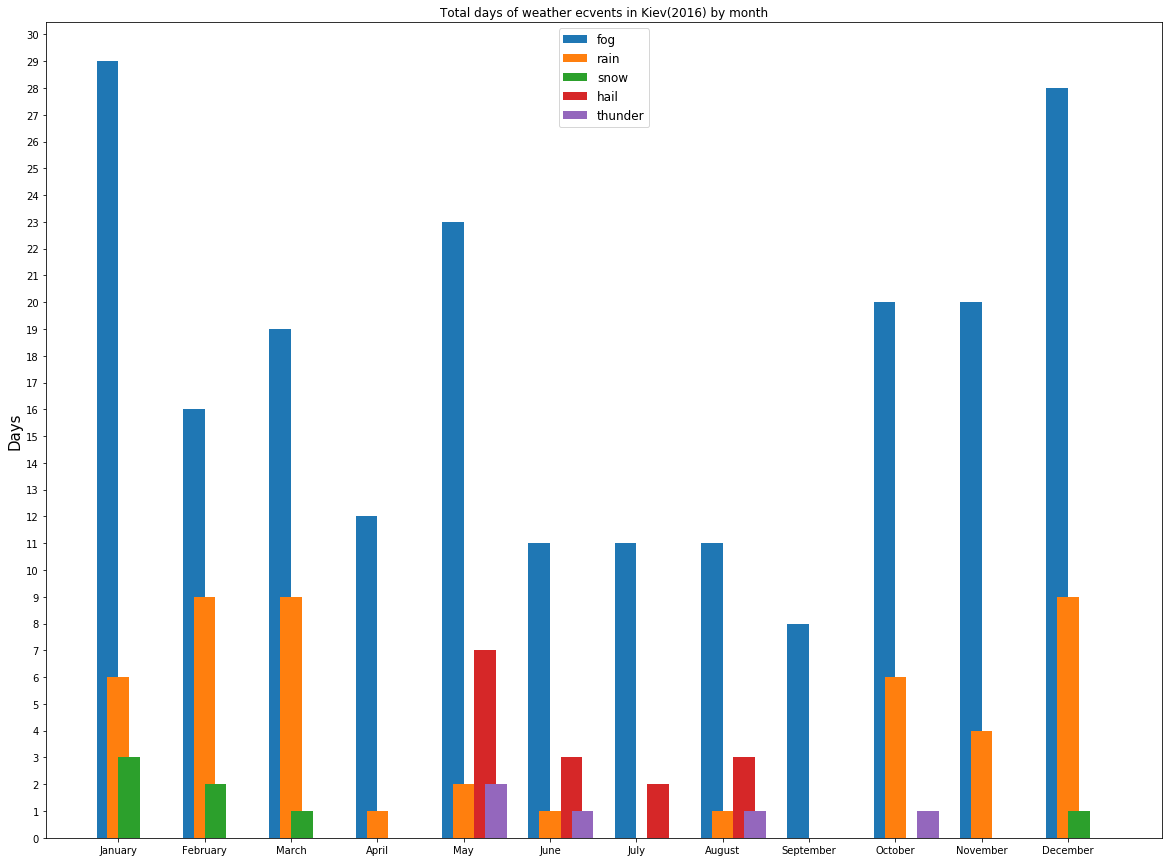

In [87]:
fix, ax = plt.subplots(figsize = (20, 15));
labels = xax
x = np.arange(len(labels))
width = 0.25

bar1 = ax.bar(x-width/2, fogbar, width, label='fog')
bar2 = ax.bar(x, rainbar, width, label='rain')
bar3 = ax.bar(x+width/2, snowbar, width, label='snow')
bar4 = ax.bar(x+width, hailbar, width, label='hail')
bar5 = ax.bar(x+1.5*width, thunderbar, width, label='thunder')

ax.set_ylabel('Days', fontsize=15)
ax.set_title('Total days of weather ecvents in Kiev(2016) by month')
ax.set_yticks(np.arange(31))
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(prop={'size': 12})

plt.show()

#### Barplot of weather observations with plotly


In [88]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=xax,
    y=fogbar,
    name='fog',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=xax,
    y=snowbar,
    name='snow',
    marker_color='green'
))
fig.add_trace(go.Bar(
    x=xax,
    y=rainbar,
    name='rain',
    marker_color='blue'
))
fig.add_trace(go.Bar(
    x=xax,
    y=thunderbar,
    name='thunder',
    marker_color='goldenrod'
))
fig.add_trace(go.Bar(
    x=xax,
    y=hailbar,
    name='hail',
    marker_color='magenta'
))
for i in range(12):
    fig.add_vline(x=i+0.5, line_dash='dash', line_width=0.5)

fig.update_layout(title='Total days of weather ecvents in Kiev(2016) by month',
                  barmode='group', xaxis_tickangle=0,
                  height=600,
                  width=1000,
                  yaxis=dict(
                        title='Days',
                        titlefont_size=16,                       
                  )
             )
fig.show()